We are going to fit 3 models to estimate daily log returns of **BTC**: **OLS, Ridge, Lasso** regressions.

* Dependent (endogenous) variable: daily log returns of **BTC**

* Independent (exogenous / predictor) variables: daily log returns of **(AAPL, DXY, SPY, GOLD)**

In [238]:
# Libraries
import datetime
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf
from matplotlib import pyplot as plt
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV

In [239]:
# Download last 5 years of daily closing prices
end = datetime.datetime.now()
timedelta = datetime.timedelta(365 * 5)
start = end - timedelta

series_btc = yf.download("BTC-USD", start, end)["Adj Close"]
series_btc.name = "BTC"
series_aapl = yf.download("AAPL", start, end)["Adj Close"]
series_aapl.name = "AAPL"
series_dxy = yf.download("DX-Y.NYB", start, end)["Adj Close"]
series_dxy.name = "DXY"
series_spy = yf.download("SPY", start, end)["Adj Close"]
series_spy.name = "SPY"
series_gold = yf.download("GC=F", start, end)["Adj Close"]
series_gold.name = "GOLD"

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [240]:
asset_series = [series_btc, series_aapl, series_dxy, series_spy, series_gold]
dfdict = {}

# Calculate log returns and store them in a list where keys are tickers
for series in asset_series:
    dfdict[series.name] = np.log(series / series.shift(1))
    # print("series name =", series.name)

df = pd.DataFrame(dfdict)
df = df.dropna()  # drop NaN values

df

,BTC,AAPL,DXY,SPY,GOLD
Date,,,,,
2018-11-20,-0.090076,-0.048957,0.006425,-0.018680,-0.003358
2018-11-21,0.033204,-0.001131,-0.001033,0.003402,0.005563
2018-11-23,-0.004322,-0.025727,0.002169,-0.006701,-0.003924
2018-11-26,-0.059290,0.013433,0.001546,0.016015,-0.000655
2018-11-27,0.010945,-0.002179,0.003086,0.003359,-0.007403
...,...,...,...,...,...
2023-11-10,0.016778,0.022955,-0.000472,0.015484,-0.016219
2023-11-13,-0.015014,-0.008621,-0.001891,-0.000954,0.006653
2023-11-14,-0.026784,0.014185,-0.014778,0.019215,0.008343


We take first 4 years as the **training set** and the last year as the **test set**

In [241]:
nrows = len(df.index)
train_df = df.iloc[0:int(nrows * 0.8), :]
test_df = df.iloc[int(nrows * 0.8):, :]

print(train_df)
print(test_df)

                 BTC      AAPL       DXY       SPY      GOLD
Date                                                        
2018-11-20 -0.090076 -0.048957  0.006425 -0.018680 -0.003358
2018-11-21  0.033204 -0.001131 -0.001033  0.003402  0.005563
2018-11-23 -0.004322 -0.025727  0.002169 -0.006701 -0.003924
2018-11-26 -0.059290  0.013433  0.001546  0.016015 -0.000655
2018-11-27  0.010945 -0.002179  0.003086  0.003359 -0.007403
...              ...       ...       ...       ...       ...
2022-11-09 -0.154890 -0.033753  0.008448 -0.020817 -0.001169
2022-11-10  0.102037  0.085236 -0.021394  0.053497  0.023235
2022-11-11 -0.031918  0.019085 -0.017903  0.009632  0.008930
2022-11-14  0.016065 -0.009531  0.003475 -0.008543  0.004294
2022-11-15  0.015904  0.011800 -0.002441  0.008493  0.000113

[1004 rows x 5 columns]
                 BTC      AAPL       DXY       SPY      GOLD
Date                                                        
2022-11-16 -0.012826 -0.008366 -0.001128 -0.007658 -0.000451

As we can see, 

* **training data** spans from 2018-11-20 to 2022-11-15
* **test data** spans from 2022-11-16 to 2023-11-16 (today)

Then we can split **dependent** and **independent** variables to different dataframes:

In [242]:
# x dataframes are dataframes of predictor variables,
# y dataframes are dataframes of dependent variables.

train_x = train_df.iloc[:, 1:]
train_y = train_df.iloc[:, 0]

test_x = test_df.iloc[:, 1:]
test_y = test_df.iloc[:, 0]

print(train_x)
print(train_y)
print(test_x)
print(test_y)

                AAPL       DXY       SPY      GOLD
Date                                              
2018-11-20 -0.048957  0.006425 -0.018680 -0.003358
2018-11-21 -0.001131 -0.001033  0.003402  0.005563
2018-11-23 -0.025727  0.002169 -0.006701 -0.003924
2018-11-26  0.013433  0.001546  0.016015 -0.000655
2018-11-27 -0.002179  0.003086  0.003359 -0.007403
...              ...       ...       ...       ...
2022-11-09 -0.033753  0.008448 -0.020817 -0.001169
2022-11-10  0.085236 -0.021394  0.053497  0.023235
2022-11-11  0.019085 -0.017903  0.009632  0.008930
2022-11-14 -0.009531  0.003475 -0.008543  0.004294
2022-11-15  0.011800 -0.002441  0.008493  0.000113

[1004 rows x 4 columns]
Date
2018-11-20   -0.090076
2018-11-21    0.033204
2018-11-23   -0.004322
2018-11-26   -0.059290
2018-11-27    0.010945
                ...   
2022-11-09   -0.154890
2022-11-10    0.102037
2022-11-11   -0.031918
2022-11-14    0.016065
2022-11-15    0.015904
Name: BTC, Length: 1004, dtype: float64
              

## OLS regression:

**REMINDER**: Don't forget to add **intercept** !

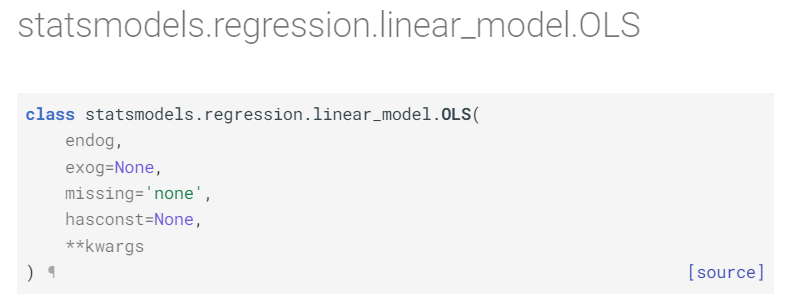
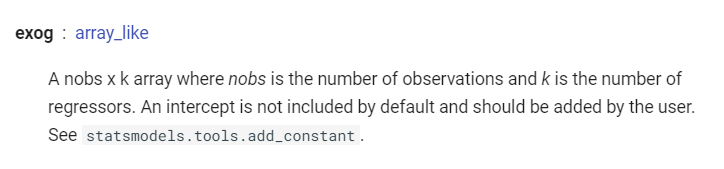

In [243]:
# Create beta (coefficients) and R^2 dicts to store model values
beta_dict = {}
rsquared_dict = {}

In [244]:
# Fit an OLS model, noticce this is the training set.
model_ols = sm.OLS(train_y, sm.add_constant(train_x)).fit()

# Store the coefficients beta
beta_dict["OLS"] = model_ols.params

# Print our results
print(model_ols.summary())
print("_" * 50)
print("Coefficients beta:")
print(model_ols.params)
print(type(model_ols.params))  # params is a pd.Series object


                            OLS Regression Results                            
Dep. Variable:                    BTC   R-squared:                       0.132
Model:                            OLS   Adj. R-squared:                  0.128
Method:                 Least Squares   F-statistic:                     37.96
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.34e-29
Time:                        16:23:22   Log-Likelihood:                 1816.5
No. Observations:                1004   AIC:                            -3623.
Df Residuals:                     999   BIC:                            -3598.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0007      0.001      0.549      0.5

After we get coefficients $\beta$ from the training set, we run our **OLS** model with the **test set**:

In [245]:
# Get y^ (fitted values) values
yhat_ols = model_ols.predict(sm.add_constant(test_x))

# Get actual values
y = test_y

# Calculate residual sum of squares (RSS)
rss_ols = np.sum(np.power((y - yhat_ols), 2))

# Calculate sample variance
samplevar_ols = np.var(y)

# Calculate R^2 from RSS and sample variance
rsquared_ols = 1 - (rss_ols / (samplevar_ols * len(y)))

# Store the R^2 value
rsquared_dict["OLS"] = rsquared_ols

print("R^2 =", rsquared_ols)

R^2 = 0.05903617433580233


## Standardize variables for Ridge and Lasso regressions

In [246]:
# Standardize variables
train_x_std = train_x
trainxstds = train_x.apply(lambda s: s.std(), axis=0)

for i in range(len(train_x_std.columns)):
    train_x_std.iloc[:, i] = train_x_std.iloc[:, i] / trainxstds[i]

train_y_std = train_y / train_y.std()

print(train_x_std)
print(train_y_std)

                AAPL       DXY       SPY      GOLD
Date                                              
2018-11-20 -2.226247  1.508728 -1.295932 -0.330882
2018-11-21 -0.051436 -0.242687  0.236006  0.548182
2018-11-23 -1.169892  0.509358 -0.464893 -0.386636
2018-11-26  0.610865  0.363157  1.111075 -0.064590
2018-11-27 -0.099071  0.724634  0.233034 -0.729529
...              ...       ...       ...       ...
2022-11-09 -1.534891  1.983837 -1.444223 -0.115181
2022-11-10  3.876018 -5.023932  3.711442  2.289680
2022-11-11  0.867887 -4.204009  0.668235  0.879974
2022-11-14 -0.433407  0.816030 -0.592698  0.423168
2022-11-15  0.536573 -0.573131  0.589212  0.011116

[1004 rows x 4 columns]
Date
2018-11-20   -2.116708
2018-11-21    0.780260
2018-11-23   -0.101570
2018-11-26   -1.393268
2018-11-27    0.257201
                ...   
2022-11-09   -3.639784
2022-11-10    2.397800
2022-11-11   -0.750059
2022-11-14    0.377509
2022-11-15    0.373739
Name: BTC, Length: 1004, dtype: float64


/tmp/ipykernel_249/3877719660.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  train_x_std.iloc[:, i] = train_x_std.iloc[:, i] / trainxstds[i]


## Ridge Regression:

In [247]:
# Generate a sequence of lambdas to try
lambdas = [np.power(10, i) for i in np.arange(6, -6, -0.1)]
alphas = lambdas
print("lambdas =", lambdas)

# Use 10-fold Cross Validation to find optimal lambda
# using training set
model_ridge_cv = RidgeCV(alphas=alphas, cv=10, scoring="neg_mean_squared_error").fit(train_x, train_y)
print("optimal lambda =", model_ridge_cv.alpha_)

lambdas = [1000000.0, 794328.2347242822, 630957.3444801943, 501187.2336272735, 398107.17055349855, 316227.76601683925, 251188.64315095925, 199526.23149688912, 158489.3192461124, 125892.54117941765, 100000.00000000081, 79432.82347242886, 63095.734448019946, 50118.72336272776, 39810.71705535018, 31622.77660168418, 25118.86431509613, 19952.623149689072, 15848.931924611368, 12589.254117941868, 10000.000000000164, 7943.282347242952, 6309.573444802046, 5011.872336272817, 3981.0717055350506, 3162.277660168444, 2511.8864315096334, 1995.2623149689236, 1584.8931924611497, 1258.925411794197, 1000.0000000000246, 794.3282347243016, 630.9573444802097, 501.1872336272858, 398.1071705535083, 316.227766016847, 251.18864315096542, 199.526231496894, 158.48931924611628, 125.89254117942073, 100.00000000000327, 79.43282347243081, 63.095734448021496, 50.11872336272899, 39.810717055351155, 31.622776601684958, 25.118864315096747, 19.952623149689565, 15.848931924611756, 12.589254117942177, 10.000000000000409, 7.

optimal lambda = 19.952623149689565


In [248]:
# Using optimal lambda, fit ridge model with training data
model_ridge = Ridge(alpha=model_ridge_cv.alpha_, fit_intercept=True).fit(train_x, train_y)

# Create result coefficients beta to a Series and store it
myzip = zip(model_ridge.feature_names_in_, model_ridge.coef_)

coefdict_ridge = {"const":model_ridge.intercept_}
for name, coef in myzip:
    coefdict_ridge[name] = coef

# Store the coefficients
beta_dict["Ridge"] = pd.Series(coefdict_ridge)

In [249]:
# Get y^ (fitted values) values
yhat_ridge = model_ridge.predict(test_x)

# Get actual values
y = test_y

# Calculate residual sum of squares (RSS)
rss_ridge = np.sum(np.power(y - yhat_ridge, 2))

# Calculate denominator of R^2
denom_r2 = np.sum(np.power(y - np.mean(y), 2))

# Calculate R^2 from RSS and sample variance
rsquared_ridge = 1 - (rss_ridge / denom_r2)

# Store the R^2 value
rsquared_dict["Ridge"] = rsquared_ridge

print("R^2 =", rsquared_ridge)

R^2 = 0.0007458450756282486


## Lasso regression:

In [250]:
# Generate a sequence of lambdas to try
lambdas = [np.power(10, i) for i in np.arange(6, -6, -0.1)]
alphas = lambdas
print("lambdas =", lambdas)

# Use 10-fold Cross Validation to find optimal lambda
# using training set
model_lasso_cv = LassoCV(alphas=alphas, cv=10).fit(train_x, train_y)
print("optimal lambda =", model_lasso_cv.alpha_)

lambdas = [1000000.0, 794328.2347242822, 630957.3444801943, 501187.2336272735, 398107.17055349855, 316227.76601683925, 251188.64315095925, 199526.23149688912, 158489.3192461124, 125892.54117941765, 100000.00000000081, 79432.82347242886, 63095.734448019946, 50118.72336272776, 39810.71705535018, 31622.77660168418, 25118.86431509613, 19952.623149689072, 15848.931924611368, 12589.254117941868, 10000.000000000164, 7943.282347242952, 6309.573444802046, 5011.872336272817, 3981.0717055350506, 3162.277660168444, 2511.8864315096334, 1995.2623149689236, 1584.8931924611497, 1258.925411794197, 1000.0000000000246, 794.3282347243016, 630.9573444802097, 501.1872336272858, 398.1071705535083, 316.227766016847, 251.18864315096542, 199.526231496894, 158.48931924611628, 125.89254117942073, 100.00000000000327, 79.43282347243081, 63.095734448021496, 50.11872336272899, 39.810717055351155, 31.622776601684958, 25.118864315096747, 19.952623149689565, 15.848931924611756, 12.589254117942177, 10.000000000000409, 7.

In [251]:
# Fit a Lasso model with optimal lambda
model_lasso = Lasso(model_lasso_cv.alpha_, fit_intercept=True).fit(train_x, train_y)
coefdict_lasso = {"const":model_lasso.intercept_}

for name, coef in zip(model_lasso.feature_names_in_, model_lasso.coef_):
    coefdict_lasso[name] = coef
    
# Store coefficients beta
beta_dict["Lasso"] = pd.Series(coefdict_lasso)

In [252]:
# Now test our Lasso model with test data

# Get y^ (fitted values) values
yhat_lasso = model_lasso.predict(test_x)

# Get actual values
y = test_y

# Calculate residual sum of squares (RSS)
rss_lasso = np.sum(np.power(y - yhat_lasso, 2))

# Calculate denominator of R^2
denom_r2 = np.sum(np.power(y - np.mean(y), 2))

# Calculate R^2 from RSS and sample variance
rsquared_lasso = 1 - (rss_lasso / denom_r2)

# Store the R^2 value
rsquared_dict["Lasso"] = rsquared_lasso

print("R^2 =", rsquared_lasso)

R^2 = 0.0007605667191709076


In [253]:
r2_series = pd.Series(rsquared_dict, name="R squared")
coef_df = pd.DataFrame(beta_dict)
# results_df = pd.concat([coef_df, r2_series], axis=1)
coef_df.loc["R squared", :] = r2_series
coef_df

,OLS,Ridge,Lasso
const,0.000691,0.000684,0.000699
AAPL,0.016765,0.000916,0.000276
DXY,-0.829134,-0.003538,-0.003437
SPY,0.907398,0.012389,0.013024
GOLD,0.345068,0.003453,0.003389
R squared,0.059036,0.000746,0.000761
